# Numpy 一维DFT

## 理论背景

- 宏观世界：经典力学
- 纳米尺度：量子力学

量子力学用薛定谔方程描述物理体系：

$$
\hat{H} \Psi=[\hat{T}+\hat{V}+\hat{U}] \Psi=\left[\sum_{i=1}^N\left(-\frac{\hbar^2}{2 m_i} \nabla_i^2\right)+\sum_{i=1}^N V\left(\mathbf{r}_i\right)+\sum_{i<j}^N U\left(\mathbf{r}_i, \mathbf{r}_j\right)\right] \Psi=E \Psi \tag{1}
$$

式1计算复杂度随电子数量N快速上升。密度泛函理论（DFT）大幅降低了计算量（将多电子体系的薛定谔方程转化成单电子形式KS方程，将精度损失全部归入交换关联泛函），使得通过数值计算分析纳米材料物化性质成为可能。

$$
\left[-\frac{\hbar^2}{2 m} \nabla^2+V_{\mathrm{s}}(\mathbf{r})\right] \varphi_i(\mathbf{r})=\varepsilon_i \varphi_i(\mathbf{r}) \tag{2}
$$

$$
V_{\mathrm{s}}(\mathbf{r})=V(\mathbf{r})+\int \frac{n\left(\mathbf{r}^{\prime}\right)}{\left|\mathbf{r}-\mathbf{r}^{\prime}\right|} \mathrm{d}^3 \mathbf{r}^{\prime}+V_{\mathrm{XC}}[n(\mathbf{r})] \tag{3}
$$

$$
n(\mathbf{r})=\sum_{i=1}^N\left|\varphi_i(\mathbf{r})\right|^2 \tag{4}
$$

式2到式4所示KS方程聚焦体系能量和电子密度的关系，二者一一对应（原则上，其他物化性质在求出这两项后可另行导出）。在量子力学中，能量与哈密顿量（算符）对应，而电子密度与波函数对应。**问题归结为如何正确写出作用在体系波函数上的哈密顿量（式2括号中内容）并求解KS方程**（更多细节请阅读 [wiki](https://en.wikipedia.org/wiki/Density_functional_theory) 或相关书籍）。

## 代码概述

- 理论部分见[此PDF](./Larsen_Lyon_Theory.pdf)
- 目标: 针对一维谐振子，考虑动能、静电势、LDA，忽略关联项；写出这种情况下体系的KS方程并求解

根据KS方程通用形式，哈密顿量由 动能和势能 组成：

$$\hat{H}=-\frac{1}{2}\frac{d^2}{dx^2}+v_s(x)$$

势能包含 外部势（谐振子为$x^2$）、电子库伦势（Hartree）和电子交互关联势（局域密度近似LDA）

$$v_s(x)=x^2+v_{Hartree}(x)+v_{LDA}(x)$$

如何代码实现并求解上述方程？

## 逐个击破

顺序：
- 动能
- 外部势（一维谐振子，就是$x^2$）
- 电子库伦势 Hartree
- 电子交互关联式 LDA

注意，本项目并不写for循环自洽求解，而是调用第三方库直接求解已经写好的哈密顿量的本征值和本征函数。问题只有一个：如何写出哈密顿量？

### 先数值表示动能（算符）

如何数值表示二阶微分？

二阶微分基于一阶微分，一阶导的数值表示形式：

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

然而我们没有网格上的具体值（求解KS方程之前未知），要想办法将算符与网格值剥离（变成向量相乘的形式），类似这样：

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$

为此，我们可以定义一阶导算符：

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$


- 端点处的导数不好定义，暂时忽略这个不算太大的问题
- $\delta_{ij}$ 是 Kronecker delta
- 使用了爱因斯坦求和约定

In [2]:
import numpy as np

n_grid_demo=5
x=np.linspace(-5,5,n_grid_demo)
h=x[1]-x[0]

d_i1j = np.diagflat(np.ones(n_grid_demo-1),1)
print(f'd_i1j\n', d_i1j)
d_ij = np.eye(n_grid_demo)
print(f'd_ij\n', d_ij)
D=(d_i1j - d_ij)/h
print(f'D\n', D)

d_i1j
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]
d_ij
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
D
 [[-0.4  0.4  0.   0.   0. ]
 [ 0.  -0.4  0.4  0.   0. ]
 [ 0.   0.  -0.4  0.4  0. ]
 [ 0.   0.   0.  -0.4  0.4]
 [ 0.   0.   0.   0.  -0.4]]


同样的我们想把二阶微分算符剥离出来：

$$(\frac{d^2y}{dx^2})_{i}=D^2_{ij} y_{j}$$

二阶算符就应该表示成:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

它和一阶算符之间存在一些运算关系:

$$D^2_{ij}=-D_{ik}D_{jk}$$

In [3]:
d_in1j = np.diagflat(np.ones(n_grid_demo-1),-1)
print(f'd_in1j\n', d_in1j)
D2ij = (d_i1j - 2*d_ij + d_in1j)/ h**2
print(f'D2ij\n', D2ij)

D2=D.dot(-D.T)
print('D2')
print(D2)
D2[-1,-1]=D2[0,0] # 由于周期性边界条件，最后一个元素需要特殊处理
print(D2)

d_in1j
 [[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
D2ij
 [[-0.32  0.16  0.    0.    0.  ]
 [ 0.16 -0.32  0.16  0.    0.  ]
 [ 0.    0.16 -0.32  0.16  0.  ]
 [ 0.    0.    0.16 -0.32  0.16]
 [ 0.    0.    0.    0.16 -0.32]]
D2
[[-0.32  0.16  0.    0.    0.  ]
 [ 0.16 -0.32  0.16  0.    0.  ]
 [ 0.    0.16 -0.32  0.16  0.  ]
 [ 0.    0.    0.16 -0.32  0.16]
 [ 0.    0.    0.    0.16 -0.16]]
[[-0.32  0.16  0.    0.    0.  ]
 [ 0.16 -0.32  0.16  0.    0.  ]
 [ 0.    0.16 -0.32  0.16  0.  ]
 [ 0.    0.    0.16 -0.32  0.16]
 [ 0.    0.    0.    0.16 -0.32]]


采用最经典的正弦函数例子，验证上述两个算符是否正确

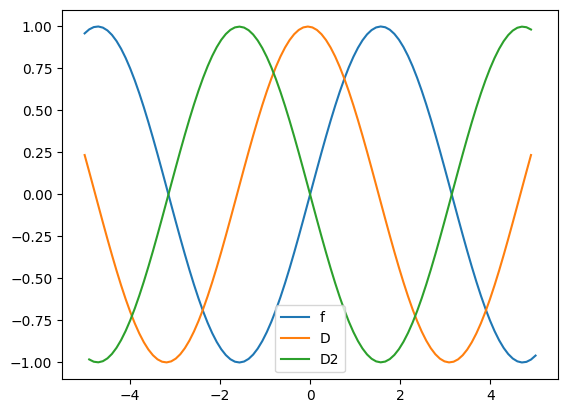

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n_grid=100 # 为画图较平滑，取较大的n_grid
x=np.linspace(-5,5,n_grid)
h=x[1]-x[0]
D=(-np.eye(n_grid)+np.diagflat(np.ones(n_grid-1),1))/h
D2=D.dot(-D.T)
D2[-1,-1]=D2[0,0]

y=np.sin(x)
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

可以看到结果符合三角函数的性质，将$D$和$D^2$两个算符作用到函数上，确实得到了它的一阶而二阶导数

我们可以先不管势能项，试试看只有动能项的时候（自由电子）KS方程求解出来会是什么样子

注：在量子力学中，所有可观测物理量 $A$ 都有一个对应的算符 $\hat{A}$，代表作用于波函数的一种运算。

$$\hat{A} \psi = a \psi$$

$a$ 即算符本征值，$\psi$ 是算符 $A$ 的本征态。对这个本征态波函数 $\psi$ 测量可观测物理量 $A$，得到的值就是 $a$

类似的，如果想要求出体系的总能量，需要求解哈密顿算符的本征值。求出本征值的同时，本征态也会求出，对应特定状态下的波函数（我们预先并不知道体系的波函数长什么样子）。

- 不考虑电子相互作用时，体系的哈密顿量:

$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- 直接调用现成的线性代数求解器:

In [5]:
eig_non, psi_non=np.linalg.eigh(-D2/2)
print(len(eig_non))

100


- 求出本征值和对应的本征态后，绘图观察

In [ ]:
for i in range(5):
    plt.plot(x,psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

所绘制的曲线反映的就是波函数（能量的本征态）的信息，而图例中写的则是对应的能量（能量的本征值）大小

后面的求解原理类似，只不过逐渐追加哈密顿算符的组分，都直接调用成熟的线性代数求解器完成本征值问题求解

In [ ]:
# 外势
X=np.diagflat(x*x)
print(X)

### 引入交换关联势和库伦势

多电子体系最麻烦的地方在于电子之间的相互作用，上面我们考虑了体系整体动能、外部势能，但是还没有考虑到电子之间的相互作用能。**我们需要先得到电子的信息——电荷密度分布，然后才能导出库仑势和交换关联势**

先定义几个常用的函数
- 积分
- 波函数必须满足归一化要求:

$$\int \lvert \psi \rvert ^2 dx = 1$$


In [ ]:
# 积分
def integral(x,y,axis=0):
    dx=x[1]-x[0]
    return np.sum(y*dx, axis=axis)

# 归一化的波函数
def get_np(psi, x):
    # normalization
    I=integral(x,psi**2,axis=0)
    normed_psi=psi/np.sqrt(I)[None, :]
    return normed_psi

接下来可以求出电荷密度

- 定义 $f_n$ 为占据数, 电荷密度 $n(x)$ 可以写成:

$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

- 注意:
    - DFT框架下，求解的都是最低能量态（基态）
    - 每个态最多只能容纳两个电子，自旋分别向上和向下
    - 电子从低能级到高能级依次填充

In [ ]:
def get_nx(num_electron, psi, x):
    normed_psi=get_np(psi,x) # 调用上面的函数将波函数归一化

    # occupation num
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # density
    nx=np.zeros_like(normed_psi[:,0])
    for ne, psi in zip(fn,normed_psi.T):
        nx += ne*(psi**2)
    return nx

准备工作做好后，试试看随便给定n个电子，体系的电荷密度长什么样？以及外部势对此有什么影响？

In [ ]:
# number of electrons
num_electron=17

# 没有外势
plt.plot(get_nx(num_electron,psi_non, x), label="non")
# 外势为x^2
plt.plot(get_nx(num_electron,psi_harm, x), label="harm")
# 外势为无限深势阱
plt.plot(get_nx(num_electron,psi_well, x), label="well")
# 打上标签
plt.legend(loc=1)

有了电荷密度，就可以根据理论公式，写出电荷密度泛函项

#### 库仑势的贡献（简化版）

$$ E_{Ha}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

其中 $\varepsilon$ 是一个小正数

- 库伦势:
$$ v_{Ha}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- 统一写成矩阵形式
$$E_{Ha} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Ha, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

#### 交换能的贡献（忽略关联势）

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- 交换势是能量的导数:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

In [ ]:
def get_exchange(nx,x):
    energy=-3./4.*(3./np.pi)**(1./3.)*integral(x,nx**(4./3.))
    potential=-(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

def get_hatree(nx,x, eps=1e-1):
    h=x[1]-x[0]
    energy=np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential=np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return energy, potential

## 激动人心的最终boss

将上述所有项目加到一起，开始自洽求解电荷密度、本征态等

流程：
1. 随便猜一个电荷密度分布
2. 计算泛函项（交换关联势和库仑势）
3. 把它们加入哈密顿量
4. 求出哈密顿量的本征值和对应的本征态
5. 根据本征态积分出电荷密度，与猜测的对比，如果差别很大，重复这个流程

In [ ]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

max_iter=1000
energy_tolerance=1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

# 1
nx=np.zeros(n_grid)

for i in range(max_iter):
    # 2
    ex_energy, ex_potential=get_exchange(nx,x)
    ha_energy, ha_potential=get_hatree(nx,x)
    
    # 3
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    # 4
    energy, psi= np.linalg.eigh(H)
    
    # 5
    ## 记录
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    ## 检查是否收敛
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break
    ## 更新电荷密度分布
    nx=get_nx(num_electron,psi,x)
    ## 也可以用beta参数混合新旧电荷密度，加速收敛
    # beta=0.1
    # nx=beta*get_nx(num_electron,psi,x) + (1-beta)*nx
    
else:
    print("not converged")

求解完成！让我们看看这个简单体系的本征值和本征态长什么样？

In [ ]:
for i in range(5):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

看起来还不错，那么电荷密度分布呢？与前面只有动能项的那个比较一下

In [ ]:
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.plot(get_nx(num_electron,psi_non,x), label="动")
plt.plot(get_nx(num_electron,psi_harm,x), label="动+外势")
plt.plot(nx, label="动+外势+交换+库伦")
plt.legend()